# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import credit_functions
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from scipy import stats
from sklearn.ensemble import RandomForestClassifier



pd.set_option('display.max_columns',300)

## 1. Data Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

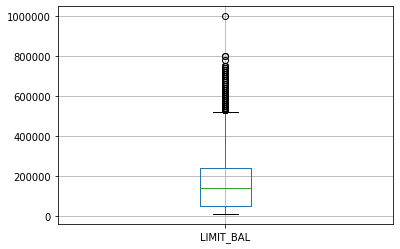

In [4]:
df.boxplot('LIMIT_BAL')
df=df[df['LIMIT_BAL']<900000]

In [5]:
df.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
df= credit_functions.replace_unknowns(df)

## 2. EDA

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,23998.0,15027.888532,8654.531002,1.0,7507.50,15027.5,22531.75,30000.0
LIMIT_BAL,23998.0,167791.052588,129806.706831,10000.0,50000.00,140000.0,240000.00,800000.0
SEX,23998.0,1.603592,0.489161,1.0,1.00,2.0,2.00,2.0
EDUCATION,23998.0,1.783440,0.730614,0.0,1.00,2.0,2.00,3.0
MARRIAGE,23998.0,1.517918,0.524588,0.0,1.00,2.0,2.00,2.0
AGE,23998.0,35.522752,9.253882,21.0,28.00,34.0,42.00,79.0
PAY_1,23998.0,-0.014960,1.120926,-2.0,-1.00,0.0,0.00,8.0
PAY_2,23998.0,-0.134845,1.193069,-2.0,-1.00,0.0,0.00,8.0
PAY_3,23998.0,-0.165639,1.193539,-2.0,-1.00,0.0,0.00,8.0
PAY_4,23998.0,-0.217060,1.168732,-2.0,-1.00,0.0,0.00,8.0


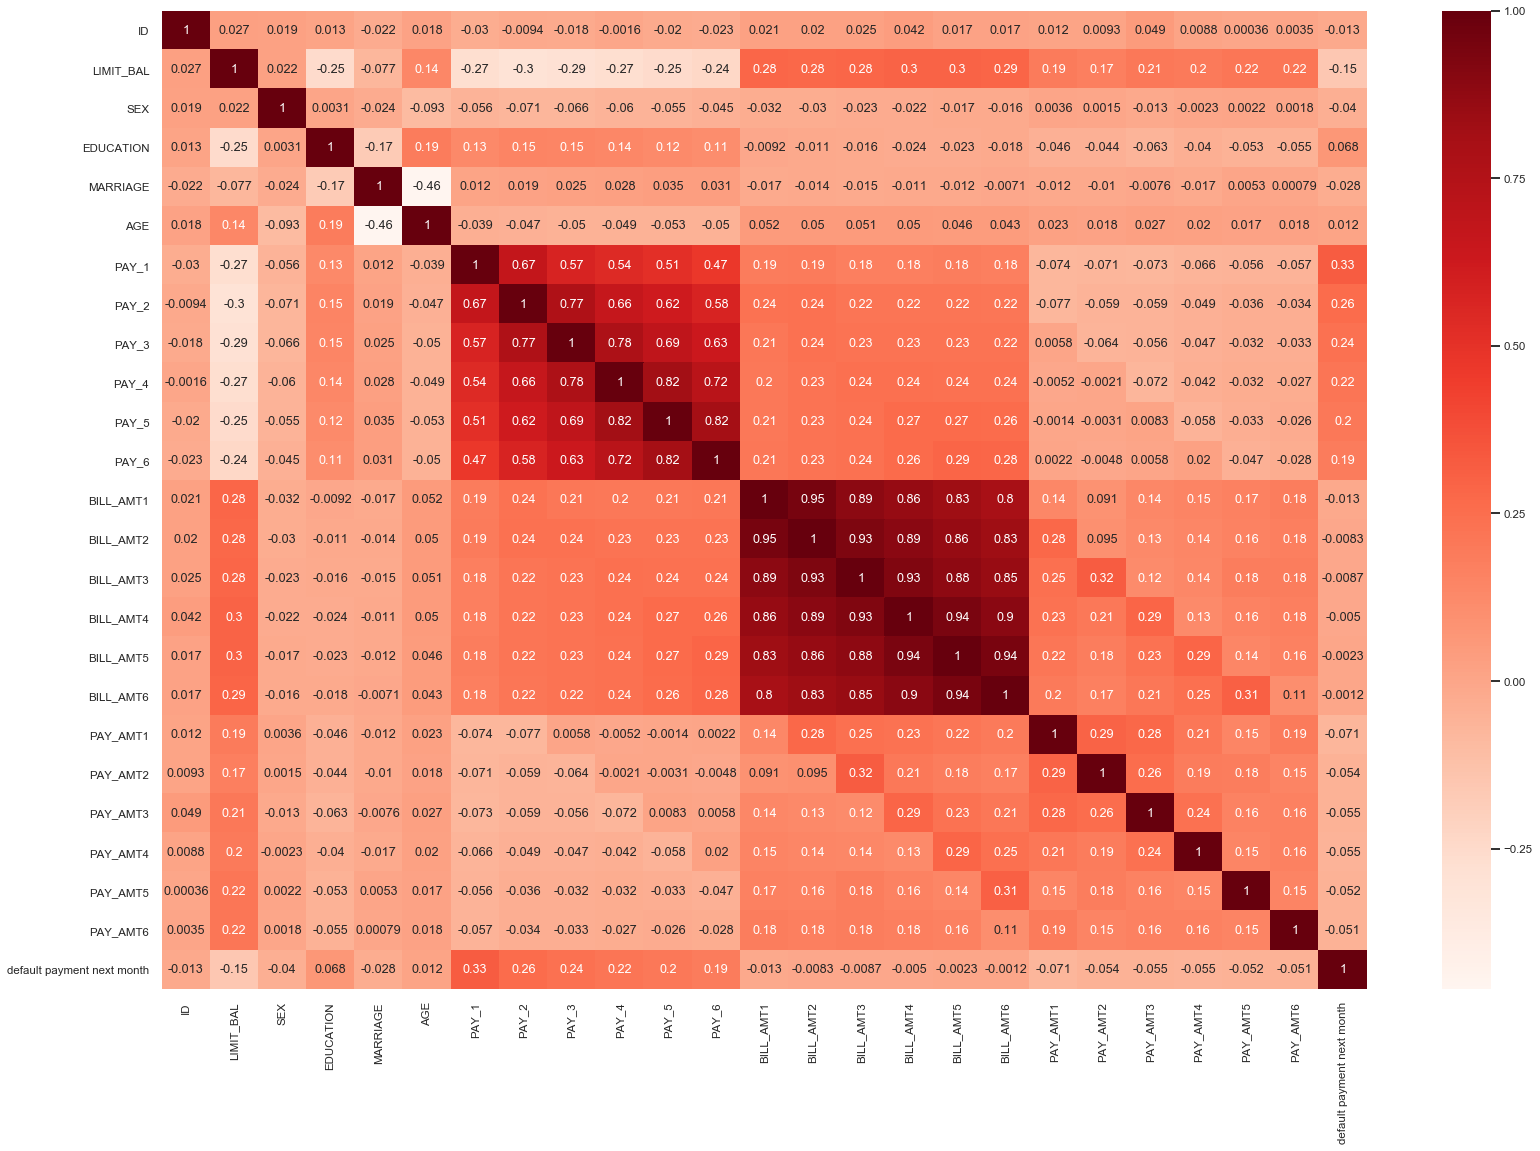

In [7]:
sns.set(rc = {'figure.figsize':(27,18)})
sns.set_context('talk' , font_scale=0.7)
sns.heatmap(df.corr(),cmap='Reds' , annot=True)

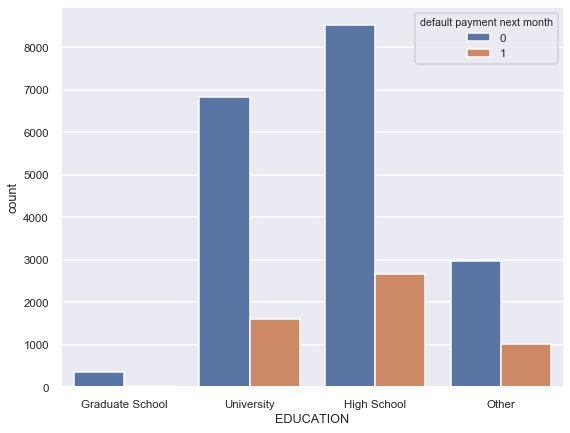

In [8]:
# EDA for education vs default payment
sns.set(rc = {'figure.figsize':(9,7)})
sns.set_context('talk' , font_scale=0.7)
edu = sns.countplot(x = 'EDUCATION'  ,hue='default payment next month', data = df)
edu.set_xticklabels(['Graduate School' , 'University' , 'High School' , 'Other'])
plt.show()

In [9]:
default0 = df.groupby(df['EDUCATION'][df['default payment next month']==0]).size().reset_index(name = "NOT_DEFAULT")
default1 = df.groupby(df['EDUCATION'][df['default payment next month']==1]).size().reset_index(name = "DEFAULT")
total = df.groupby(df['EDUCATION']).size().reset_index(name = "Total")
eduTable = default0.join(default1['DEFAULT']).join(total['Total'])
eduTable


,EDUCATION,NOT_DEFAULT,DEFAULT,Total
0,0.0,351,24,375
1,1.0,6825,1616,8441
2,2.0,8532,2656,11188
3,3.0,2982,1012,3994


In [10]:
graduate_school_default=1616/8442
university_default=2656/11188
high_school_default=1012/3994
print("graduate school:",graduate_school_default)
print("university:",university_default)
print("high school:",high_school_default)
# The more education people have, the smaller chance people will default on their payment  

graduate school: 0.191423833214878
university: 0.2373972112978191
high school: 0.25338007010515773


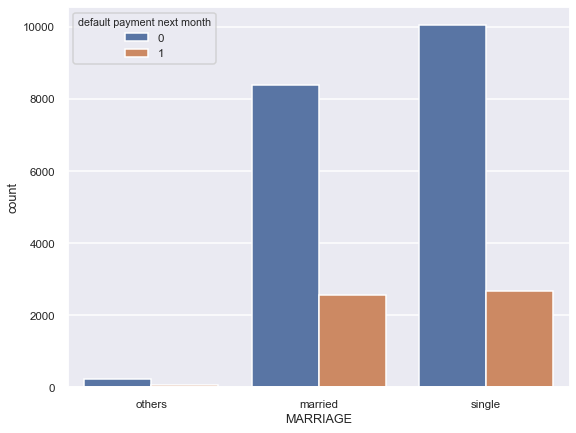

In [11]:
# EDA for marriage vs default payment
sns.set(rc = {'figure.figsize':(9,7)})
sns.set_context('talk' , font_scale=0.7)
edu = sns.countplot(x = 'MARRIAGE'  ,hue='default payment next month', data = df)
edu.set_xticklabels(['others' ,'married' , 'single'])
plt.show()

In [12]:
default3 = df.groupby(df['MARRIAGE'][df['default payment next month']==0]).size().reset_index(name = "NOT_DEFAULT")
default4 = df.groupby(df['MARRIAGE'][df['default payment next month']==1]).size().reset_index(name = "DEFAULT")
total2 = df.groupby(df['MARRIAGE']).size().reset_index(name = "Total")
eduTable = default3.join(default4['DEFAULT']).join(total2['Total'])
eduTable

,MARRIAGE,NOT_DEFAULT,DEFAULT,Total
0,0.0,234,72,306
1,1.0,8398,2559,10957
2,2.0,10058,2677,12735


In [13]:
married_people_default = 2559/10958
single_people_default = 2677/12735
print("married:",married_people_default)
print("single:",single_people_default)
# married people are slightly more risky than single people

married: 0.23352801606132506
single: 0.21020808794660384


## 3. Feature Engineering

In [14]:
df=credit_functions.calculate_utilization(df)

## 4. Feature Selection

In [15]:
df.groupby("default payment next month").mean()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,avg_utilization,avg_payment_impact,debt_streak,payment_impact1,utilization1,payment_impact2,utilization2,payment_impact3,utilization3,payment_impact4,utilization4,payment_impact5,utilization5,payment_impact6,utilization6,debt_avg_delta
default payment next month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,15087.061156,178362.867844,1.613965,1.756822,1.525629,35.463082,-0.209149,-0.302461,-0.317121,-0.353558,-0.384430,-0.400268,52063.226752,49797.111878,47777.774532,43933.082129,40785.000214,39227.584965,6318.689995,6722.328357,5712.165062,5283.601445,5256.017496,5727.580524,0.352156,0.039927,0.972178,0.046572,0.405405,0.046675,0.390213,0.038891,0.370873,0.036273,0.337723,0.035067,0.312000,0.036082,0.296723,0.040359
1.0,14819.535795,130566.631500,1.567069,1.877167,1.490769,35.732856,0.668802,0.455350,0.367747,0.263564,0.172005,0.116993,49747.367182,48375.900716,46316.264506,43156.267332,40450.943293,39050.490580,3457.516014,3536.671628,3469.873587,3199.404861,3298.986247,3540.212698,0.451897,0.035513,0.781462,0.041238,0.493579,0.037290,0.488929,0.035928,0.472390,0.032752,0.442846,0.032383,0.413412,0.033486,0.400230,0.032053


In [16]:
excluded = credit_functions.exclude_columns(["PAY_AMT", "BILL_AMT", "payment_impact","utilization"])
selection = df.drop(columns = excluded).columns
selection

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'avg_utilization',
       'avg_payment_impact', 'debt_streak', 'debt_avg_delta'],
      dtype='object')

## 5. Model Fitting and Hyperparameter Tuning
KNN,Random Forest,XGboost 

In [89]:
X=df[selection]
y=df['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [90]:
X_train, y_train = credit_functions.class_imbalance(X_train, y_train, "default payment next month", 0, 1, 1234)

In [91]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

Begin KNN

In [20]:
knn=KNeighborsClassifier(n_neighbors=1)

In [21]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [22]:
y_pred_class = knn.predict(X_test)

In [23]:
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1 Score:' + str(metrics.f1_score(y_test, y_pred_class)))

Accuracy:0.734375
F1 Score:0.3795620437956205


In [24]:
k_scores=[]
f_scores = []
k_range = list(range(1, 20))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    acc=metrics.accuracy_score(y_test,y_pred)
    f1 = metrics.f1_score(y_test,y_pred)
    k_scores.append(acc)
    f_scores.append(f1)
list(zip(k_scores, f_scores))

[(0.734375, 0.3795620437956205),
 (0.74125, 0.37336024217961655),
 (0.6845833333333333, 0.4095163806552262),
 (0.7027083333333334, 0.4046725073007927),
 (0.6629166666666667, 0.4217298070050036),
 (0.6933333333333334, 0.42138364779874216),
 (0.665, 0.434201266713582),
 (0.7014583333333333, 0.4395776300351975),
 (0.6764583333333334, 0.43955250811981234),
 (0.7027083333333334, 0.4419241298396559),
 (0.6814583333333334, 0.4478150957024197),
 (0.7125, 0.45967110415035234),
 (0.6939583333333333, 0.45972784111805814),
 (0.7189583333333334, 0.4736636753804136),
 (0.7002083333333333, 0.46841521980051715),
 (0.7222916666666667, 0.4741617357001972),
 (0.7016666666666667, 0.46607009694258017),
 (0.7220833333333333, 0.47231012658227844),
 (0.7077083333333334, 0.47076574877404753)]

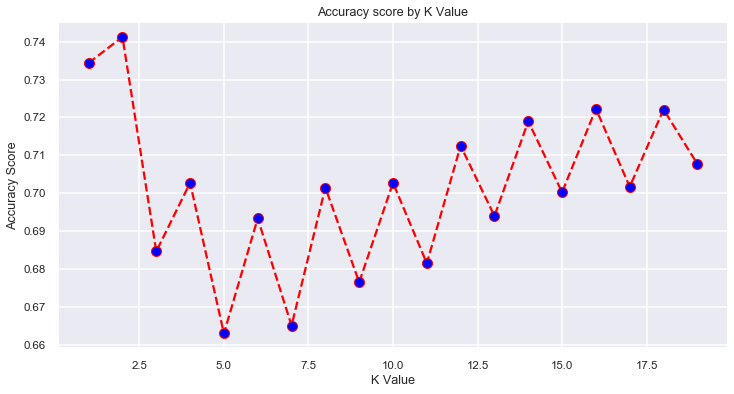

In [25]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()
# we have highest f1 score at k = 15, which is 0.41

###XG Boost 

In [26]:
xg_clf=xgb.XGBClassifier()

In [27]:
df['default payment next month'].mean()

0.22118509875822986

In [28]:
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
predictions = xg_clf.predict(X_test)
test_f1 = f1_score(y_test,predictions)
test_acc = accuracy_score(y_test,predictions)
print("F1 Score:",test_f1)
print("Accuracy:",test_acc)

F1 Score: 0.5269461077844311
Accuracy: 0.7695833333333333


In [30]:
clg_xgb = xgb.XGBClassifier(objectives='binary:logistic')
param_dist = {'n_estimators':[,200300],
              'learning_rate':[0.05,0.07],
              'max_depth':[4,5],
              'colsample_bytree':[0.5,0.4],
              'min_child_weight':[2,3]
             }

In [25]:
gim = GridSearchCV(estimator=clg_xgb,
                   param_grid=param_dist,
                   scoring='f1',
                   n_jobs=-1,
                   verbose=1,
                   iid=False,
                   cv=5)

In [ ]:
gim.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Random Forest

In [74]:
forest = RandomForestClassifier(n_estimators=200, max_depth=5, criterion='gini', n_jobs=-1,)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [75]:
y_pred = forest.predict(X_test)

In [76]:
forest_f1 = f1_score(y_test,y_pred)
forest_acc = accuracy_score(y_test,y_pred)
print("F1 Score:",forest_f1)
print("Accuracy:",forest_acc)

F1 Score: 0.5400089405453733
Accuracy: 0.785625


In [78]:
import pickle

In [79]:
 
model_pickle_path = 'best_forest_model.pkl'

# Create an variable to pickle and open it in write mode
model_pickle = open(model_pickle_path, 'wb')
pickle.dump(forest, model_pickle)
model_pickle.close()

In [ ]:
xgboost_model_pkl = open(model_pickle_path, 'rb')
xgboost_model = pickle.load(xgboost_model_pkl)
print("Loaded XGboost model :: ", xgboost_model)

In [33]:
param_dist = {'n_estimators':[100,200],
              'criterion':["gini"],
              'max_depth':[7,8,9],
              'min_samples_split':[1,2,3],
             }

In [34]:
g_forest = GridSearchCV(estimator=forest,
                   param_grid=param_dist,
                   scoring='f1',
                   n_jobs=-1,
                   verbose=1,
                   iid=False,
                   cv=5)

In [35]:
g_forest.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished
/Users/chaoalex/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=-1,
                                              oob_score=False,
                                              random_sta

In [51]:
g_forest.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 3,
 'n_estimators': 100}

In [52]:
y_pred = g_forest.predict(X_test)
metrics.f1_score(y_pred, y_test)

0.5297539149888143

## 6. Model Evaluation

## 7. Final Model

In [80]:
holdout = pd.read_csv("hold_out_features.csv")
holdout.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
holdout= credit_functions.replace_unknowns(holdout)
holdout=credit_functions.calculate_utilization(holdout)
final_X=holdout[selection]
scaler.transform(final_X)
final_y = forest.predict(final_X)
pd.Series(final_y).to_csv("predictions.csv", index=False)

/Users/chaoalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [81]:
exported = pd.read_csv('predictions.csv',header=None)

In [82]:
exported.size

6001